In [61]:
# from mat4py import loadmat
from scipy.io import loadmat
from pymatreader import read_mat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
import scipy
from mne.viz import plot_topomap 
import sepyrability.separability as sep
import sepyrability.distance as dis

In [62]:
subjects = read_mat("subjectData.mat")

In [88]:
class Data:
    def __init__(self, dataObj):
        self.subject1 = Subject(dataObj['subjectData']["preON"][0], dataObj['subjectData']["postON"][0], "Subject 1")
        self.subject2 = Subject(dataObj['subjectData']["preON"][1], dataObj['subjectData']["postON"][1], "Subject 2")
        
class Run:
    def __init__(self, eeg, header, fs):
        self.raw_eeg = np.array(eeg)
        
        trig_type = header["triggers"]["TYP"]
        trig_pos = header["triggers"]["POS"]
        
        num_trials = 0
        num_hits = 0
        num_misses = 0
        num_timeouts = 0

        trials = []
        for i, t_type in enumerate(trig_type):
            if t_type == 1000:
                num_trials += 1
                trial = {}
                trial["rest_start"] = trig_pos[i]
            elif t_type == 786:
                trial["fixation_start"] = trig_pos[i]
            elif (t_type == 769):
                trial["cue_start"] = trig_pos[i]
                trial["hand"] = "right"
            elif (t_type == 770):
                trial["cue_start"] = trig_pos[i]
                trial["hand"] = "left"
            elif (t_type == 7691) or (t_type == 7701):
                trial["execution_start"] = trig_pos[i]
            elif (t_type == 7692) or (t_type == 7702):
                trial["end"] = trig_pos[i]
                seconds = (trig_pos[i] - trial["execution_start"]) / fs
                if seconds > 7.0:
                    trial["fail_type"] = "timeout"
                    num_timeouts += 1
                else:
                    trial["fail_type"] = "miss"
                    num_misses += 1
                trial["hit"] = False
                trials.append(trial)
            elif (t_type == 7693) or (t_type == 7703):
                trial["end"] = trig_pos[i]
                trial["hit"] = True
                num_hits += 1
                
                trial["fail_type"] = "N/A"
                trials.append(trial)

        self.run_TOP = num_timeouts / num_trials
        self.run_CDA = num_hits / (num_hits + num_misses)
        self.trials = trials

class Subject:
    def __init__(self, preON, postON, subname):
        self.name = subname
        self.fs = preON['header'][0]["fs"]
        self.eegLabels = preON['header'][0]["eegLabels"]
        #not sure how to use eegLocs, it's kinda gross looking
        self.eegLocs = preON['header'][0]["eegLocs"]
        
        self.pre_stim_runs = {}
        self.post_stim_runs = {}

        runs = ["run1", "run2", "run3"]
        for i, run in enumerate(runs):
            self.pre_stim_runs[run] = Run(preON['eeg'][i], preON['header'][i], self.fs)
            self.post_stim_runs[run] = Run(postON['eeg'][i], postON['header'][i], self.fs)

        self.get_topn_fisher("pre", 10, False)
        self.get_topn_fisher("post", 10, False)
            
    def print_struct(self):
        print("Stored in Selected Subject::")
        print(f"fs: {self.fs}")
        print(f"EEG Labels: {self.eegLabels}")
        print(f"Number of runs pre-stimulation: {len(self.pre_stim_runs)}")
        print(f"Number of runs pre-stimulation: {len(self.pre_stim_runs)}")
        runs = ["run1", "run2", "run3"]
        print("Pre-Stimulation:")
        for i, run in enumerate(runs):
            print(f"    Data shape: {self.pre_stim_runs[run].raw_eeg.shape}, number of trials: {len(self.pre_stim_runs[run].trials)}")
        print("Post-Stimulation:")
        for i, run in enumerate(runs):
            print(f"    Data shape: {self.post_stim_runs[run].raw_eeg.shape}, number of trials: {len(self.pre_stim_runs[run].trials)}")

    def plot_command_delivery_accuracy(self):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle(self.name + " Command Delivery Accuracy")

        pre_CDAs = []
        post_CDAs = []

        runs = ["run1", "run2", "run3"]
        for i, run in enumerate(runs):
            pre_CDAs.append(self.pre_stim_runs[run].run_CDA)
            post_CDAs.append(self.post_stim_runs[run].run_CDA)

        if self.name == "Subject 1":
            ax1.bar([1,2,3], pre_CDAs)
            ax2.bar([1,2,3], post_CDAs)
        elif self.name == "Subject 2":
            ax1.bar([1,2,3], pre_CDAs, color ='orange')
            ax2.bar([1,2,3], post_CDAs, color='orange')

        ax1.set_title("Pre-Stimulation")
        ax2.set_title("Post-Stimulation")
    
        fig.supxlabel('Run')
        fig.supylabel('Accuracy (%/100)')

    def plot_timeout_pct(self):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle(self.name + " Timeout Percent")

        pre_TOPs = []
        post_TOPs = []

        runs = ["run1", "run2", "run3"]
        for i, run in enumerate(runs):
            pre_TOPs.append(self.pre_stim_runs[run].run_TOP)
            post_TOPs.append(self.post_stim_runs[run].run_TOP)

        if self.name == "Subject 1":
            ax1.bar([1,2,3], pre_TOPs)
            ax2.bar([1,2,3], post_TOPs)
        elif self.name == "Subject 2":
            ax1.bar([1,2,3], pre_TOPs, color ='orange')
            ax2.bar([1,2,3], post_TOPs, color='orange')

        ax1.set_title("Pre-Stimulation")
        ax1.set_ylim(0, 1)
        ax2.set_title("Post-Stimulation")
        ax2.set_ylim(0, 1)
        fig.supxlabel('Run')
        fig.supylabel('Timeout Rate (%/100)')
        
    def get_topn_fisher(self, stim_type, n, print_top=True):
        freqs_f = list(range(2,31,2)) # the frequency range we care about; for our experiment it is frequencies 4-30Hz, in 2Hz increments
        # this function gets the top N features for either pre- or post-stimultation, in descending order (best performing first) 
        if stim_type == 'pre':
            data = self.pre_stim_runs
        elif stim_type == 'post':
            data = self.post_stim_runs
        else:
            raise Exception("Must specify either 'pre' for pre-stimulation Fisher scores or 'post' for post-stimulation scores")
        
        runs = ["run1", "run2", "run3"]
        all_left = [[] for _ in range(len(runs))] # this makes a lists of lists, where the # of lists is the same as the # of runs
        all_right = [[] for _ in range(len(runs))] # idea here is that each list contains all the left/right-hand EEG data for a given run
        features_left = np.zeros((3, 14, 32)) # hardcoding because we know the size of our PSD features
        features_right = np.zeros((3, 14, 32)) # dimensions: runs x PSD features x sensors
        for i, run in enumerate(runs):
            for trial in range(20): # again, hardcoded value here because we know that there are 20 trials in each run 
                start = data[run].trials[trial]['execution_start']
                end = data[run].trials[trial]['end']
                taskdata = self.pre_stim_runs[run].raw_eeg[start:end]
                if data[run].trials[trial]['hand'] == 'left':
                    all_left[i].extend(taskdata)
                elif data[run].trials[trial]['hand'] == 'right':
                    all_right[i].extend(taskdata)
            freqs, psd_l = welch(all_left[i], fs=512, window=scipy.signal.windows.hamming(256), noverlap=0, axis=0)
            freqs, psd_r = welch(all_right[i], fs=512, window=scipy.signal.windows.hamming(256), noverlap=0, axis=0)
            features_left[i] = psd_l[2:16] # this specifies the 4-30Hz frequency range that we care about 
            features_right[i] = psd_r[2:16]

        u_l = np.mean(features_left, axis=0)
        u_r = np.mean(features_right, axis=0)
        s_l = np.var(features_left, axis=0)
        s_r = np.var(features_right, axis=0)
        
        fisher = np.abs(u_l - u_r) /  np.sqrt( (s_l**2)+(s_r**2) )
        if stim_type == 'pre':
            self.pre_fisher = fisher
            # self.pre_sparability = (sep.calculate_separability(fisher, np.array(self.eegLabels), distfun = dis.euclidian, dx = 0.02, start= 0.01, show_graph = True))
        elif stim_type == 'post':
            self.post_fisher = fisher
            # self.post_sparability = (sep.calculate_separability(fisher, np.array(self.eegLabels), distfun = dis.euclidian, dx = 0.02, start= 0.01, show_graph = True))
        
        # fisher = np.sum(fisher, axis=0)
        
        if print_top ==True:
            # find top n of our list of Fisher scores
            ind = np.argpartition(fisher, -n, axis=None)[-n:] # this and next line get the top n scores
            ind = np.flip(ind[np.argsort(fisher.flatten()[ind])])
            ind_m = np.unravel_index(ind, (14,32)) # this is a tuple of two arrays, where feature [i] is a position [i] in both arrays
                                                # the first array denotes frequency, the second denotes sensor 
            top_feats = [(self.eegLabels[ind_m[1][i]], freqs_f[ind_m[0][i]]) for i in range(n)]
            print(top_feats)

        
    def plot_topo(self, stim_type):
        
        if stim_type == 'pre':
            print(f"{self.name} Pre-Stimulation:")
            scores = np.sum(self.pre_fisher, axis=0)
        elif stim_type == 'post':
            print(f"{self.name} Post-Stimulation:")
            scores = np.sum(self.post_fisher, axis=0)
        order = np.array([(-0.025,0.07),(0,0.075),(0.025,0.07),(-0.065,0.045),(-0.035,0.04),(0,0.04),(0.035,0.04),(0.065,0.045),
                #       fc5            fc1            fc2           fc6        m1                t7         c3
                  (-0.045,0.023), (-0.02,0.023), (0.02,0.023), (0.045,0.023), (-0.09,0.028), (-0.07,0), (-0.035,0),
                #   cz         c4         t8           m2        cp5               cp1            cp2
                  (0,0),   (0.035,0),  (0.07,0), (0.09,0.028), (-0.045,-0.023), (-0.02,-0.023),  (0.02,-0.023),
                #  cp6                  p7              p3            pz          p4          p8
                  (0.045,-0.023), (-0.065,-0.045), (-0.035,-0.04), (0,-0.04), (0.035,-0.04), (0.065,-0.045),
               #     poz        o1           oZ     o2
                  (0,-0.055), (-0.025,-0.07), (0,-0.075),  (0.025,-0.07)
                 ])
        plot_topomap(scores, order)

In [86]:
d = Data(subjects)
d.subject1.get_topn_fisher("pre", 10)
d.subject1.get_topn_fisher("post", 10)
print()
d.subject2.get_topn_fisher("pre", 10)
d.subject2.get_topn_fisher("post", 10)

[('C3', 24), ('FC2', 26), ('C3', 22), ('O1', 22), ('T8', 26), ('F3', 22), ('CP5', 28), ('FC5', 24), ('F3', 24), ('O2', 22)]
[('P8', 24), ('P8', 28), ('T8', 20), ('CP1', 20), ('O2', 18), ('P8', 18), ('P8', 22), ('FC5', 28), ('O2', 16), ('CP1', 26)]

[('PZ', 28), ('PZ', 24), ('PZ', 26), ('PZ', 22), ('PZ', 16), ('CP2', 26), ('PZ', 18), ('CP2', 28), ('F7', 26), ('F7', 28)]
[('F7', 20), ('F7', 22), ('F7', 28), ('M1', 20), ('M1', 28), ('PZ', 26), ('F4', 16), ('O2', 20), ('CP6', 24), ('F7', 16)]


Subject 1 Post-Stimulation:


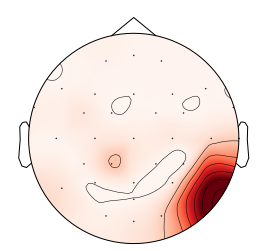

In [91]:
d = Data(subjects)
d.subject1.plot_topo("post")

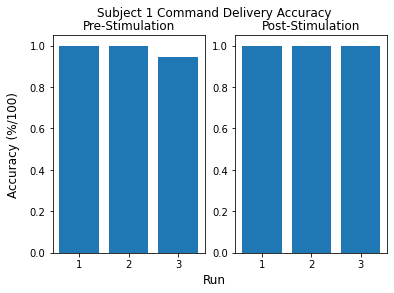

In [13]:
d = Data(subjects)
d.subject1.plot_command_delivery_accuracy()

In [57]:
d = Data(subjects)
d.subject2.get_topn_fisher('post', 10)
d.subject2.get_topn_fisher('pre', 10)
print()
d.subject1.get_topn_fisher('post', 10)
d.subject1.get_topn_fisher('pre', 10)

[('F7', 20), ('F7', 22), ('F7', 28), ('M1', 20), ('M1', 28), ('PZ', 26), ('F4', 16), ('O2', 20), ('CP6', 24), ('F7', 16)]
[('PZ', 28), ('PZ', 24), ('PZ', 26), ('PZ', 22), ('PZ', 16), ('CP2', 26), ('PZ', 18), ('CP2', 28), ('F7', 26), ('F7', 28)]

[('P8', 24), ('P8', 28), ('T8', 20), ('CP1', 20), ('O2', 18), ('P8', 18), ('P8', 22), ('FC5', 28), ('O2', 16), ('CP1', 26)]
[('C3', 24), ('FC2', 26), ('C3', 22), ('O1', 22), ('T8', 26), ('F3', 22), ('CP5', 28), ('FC5', 24), ('F3', 24), ('O2', 22)]


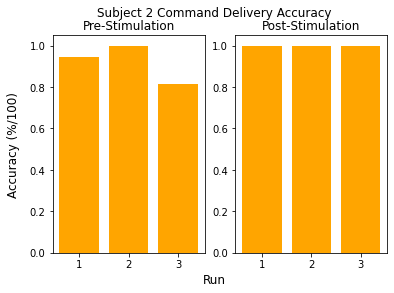

In [50]:
d = Data(subjects)
d.subject2.plot_command_delivery_accuracy()

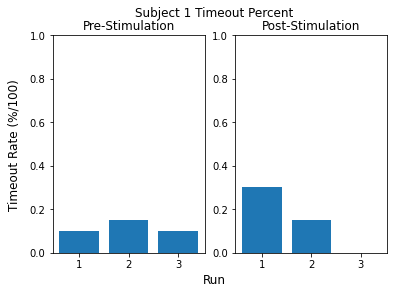

In [51]:
d = Data(subjects)
d.subject1.plot_timeout_pct()

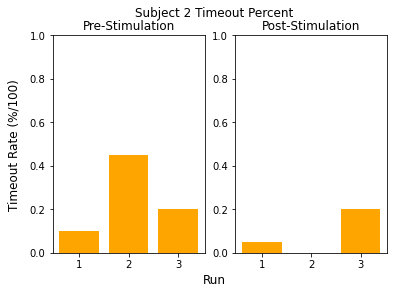

In [52]:
d = Data(subjects)
d.subject2.plot_timeout_pct()

In [10]:
d = Data(subjects)
d.subject1.print_struct()

Stored in Selected Subject::
fs: 512
EEG Labels: ['FP1', 'FPZ', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'CZ', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'PZ', 'P4', 'P8', 'POZ', 'O1', 'OZ', 'O2']
Number of runs pre-stimulation: 3
Number of runs pre-stimulation: 3
Pre-Stimulation:
    Data shape: (115200, 32), number of trials: 20
    Data shape: (115712, 32), number of trials: 20
    Data shape: (115712, 32), number of trials: 20
Post-Stimulation:
    Data shape: (138752, 32), number of trials: 20
    Data shape: (115200, 32), number of trials: 20
    Data shape: (107520, 32), number of trials: 20
